# Merge Forcing Datasets

SUMMA requires 7 input variables to run. These include:
- Precipitation rate [kg m-2 s-1]
- Downward shortwave radiation at the upper boundary [W m-2]
- Downward longwave radiation at the upper boundary [W m-2]
- Air pressure at the the measurement height [Pa]
- Air temperature at the measurement height [K]
- Wind speed at the measurement height [m s-1]
- Specific humidity at the measurement height [g g-1]

We will gather this data from the following sources:
- Precipitation (daily): Stage IV (4km), gridmet (4km), PRISM wieghted normals (800 m)
- Downward shortwave radiation (hourly/daily): CERES (downscaled 4km), gridmet (4km)
- Downward longwave radiation (hourly): CERES (downscaled 4km)
- Surface pressure (hourly): ERA5 (downscaled to 4km and corrected using standard atmosphere)
- Air temperature (daily): gridmet (4km)
- Wind speed (daily): gridmet (4km)
- Specific humidity: gridmet (4km)


In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import numpy as np 
from metpy import units, calc
from datetime import datetime
from pathlib import Path
import pandas as pd
from utils.read_files import read_from_control, make_default_path


In [2]:
# Store the name of the 'active' file in a variable
controlFile = 'control_EastRiver.txt'
# basin name and outlet gauge id
root_path = Path(read_from_control(controlFile, "root_path"))
basin = read_from_control(controlFile, "domain_name")
years = [2022, 2023]
dates = slice("2021-10-01", "2023-09-30")
forcing_location = root_path / f"domain_{basin}" / "forcing" / "1_raw_data"
dataset_paths = {
    "precipitation": {
        "stageiv": forcing_location / "stageIV" / f"stageiv_{basin}_{years[0]}_{years[1]}.nc",
        "prism_weighted": "/path/to/precipitation/prism_weighted", # not created yet
        "gridmet": forcing_location / "gridmet_pr.nc",
        },
    "temperature": {
        "gridmet": forcing_location / "gridmet_tavg.nc",
        },
    "specific_humidity": {
        "gridmet": forcing_location / "gridmet_sph.nc",
        },
    "wind": {
        "gridmet": forcing_location / "gridmet_vs.nc",
        },
    "surface_pressure": {
        "ERA5": forcing_location / f"ERA5_surface_pressure_{basin}_4km_2011_2024.nc",
        },
    "downwelling_sw":{
        "CERES": forcing_location / "broadband_shortwave_down_1h.nc",
        "gridmet": forcing_location / "gridmet_srad.nc",
        },
    "downwelling_lw":{
        "CERES": forcing_location / "broadband_longwave_down_1h.nc",
        },
    }

In [24]:
precip_ds = xr.open_dataset(dataset_paths["precipitation"]["gridmet"])
t_ds = xr.open_dataset(dataset_paths["temperature"]["gridmet"])
sph_ds = xr.open_dataset(dataset_paths["specific_humidity"]["gridmet"])
wind_ds = xr.open_dataset(dataset_paths["wind"]["gridmet"])
sp_ds = xr.open_dataarray(dataset_paths["surface_pressure"]["ERA5"])
sw_ds = xr.open_dataarray(dataset_paths["downwelling_sw"]["CERES"])
lw_ds = xr.open_dataarray(dataset_paths["downwelling_lw"]["CERES"])

# Rename dimensions to match

In [25]:
# make sure the time dimension is named "time" (not "valid_time")
def rename_dims(ds):
    if "valid_time" in ds.dims:
        ds = ds.rename({"valid_time": "time"})
    if "lat" in ds.dims:
        ds = ds.rename({"lat":"y"})
    if "lon" in ds.dims:
        ds = ds.rename({"lon":"x"})
    if "latitude" in ds.dims:
        ds = ds.rename({"latitude":"y"})
    if "longitude" in ds.dims:
        ds = ds.rename({"longitude":"x"})
    return ds

In [26]:
precip_ds = rename_dims(precip_ds)
t_ds = rename_dims(t_ds)
sph_ds = rename_dims(sph_ds)
wind_ds = rename_dims(wind_ds)
sp_ds = rename_dims(sp_ds)
sw_ds = rename_dims(sw_ds)
lw_ds = rename_dims(lw_ds)

# Clip to the same x/y coordinates

In [27]:
# make sure dimensions match in the x and y directions. If not, clip to match the smaller domain
def clip_to_match(ds1, ds2):
    if ds1.sizes["x"] > ds2.sizes["x"]:
        ds1 = ds1.isel(x=slice(0, ds2.sizes["x"]))
    elif ds1.sizes["x"] < ds2.sizes["x"]:
        ds2 = ds2.isel(x=slice(0, ds1.sizes["x"]))
    if ds1.sizes["y"] > ds2.sizes["y"]:
        ds1 = ds1.isel(y=slice(0, ds2.sizes["y"]))
    elif ds1.sizes["y"] < ds2.sizes["y"]:
        ds2 = ds2.isel(y=slice(0, ds1.sizes["y"]))
    return ds1, ds2

In [28]:
precip_ds, t_ds = clip_to_match(precip_ds, t_ds)
precip_ds, sph_ds = clip_to_match(precip_ds, sph_ds)
precip_ds, wind_ds = clip_to_match(precip_ds, wind_ds)
precip_ds, sp_ds = clip_to_match(precip_ds, sp_ds)
precip_ds, sw_ds = clip_to_match(precip_ds, sw_ds)
precip_ds, lw_ds = clip_to_match(precip_ds, lw_ds)

In [29]:
# set all x, y values to precip_ds values
def set_coords(ds1, ds2):
    ds1 = ds1.assign_coords({"x": ds2.x, "y": ds2.y})
    return ds1

In [30]:
t_ds = set_coords(t_ds, precip_ds)
sph_ds = set_coords(sph_ds, precip_ds)
wind_ds = set_coords(wind_ds, precip_ds)
sp_ds = set_coords(sp_ds, precip_ds)
sw_ds = set_coords(sw_ds, precip_ds)
lw_ds = set_coords(lw_ds, precip_ds)

# Calculate daily averages 
Defined at 7AM to 7PM UTC

In [31]:
# now calculate the average over the day where a day is defined from 7 UTC to 7 UTC the next day
def daily_average(ds):
    # convert to Mountain time
    ds['time'] = pd.to_datetime(ds['time'].values).tz_localize('UTC').tz_convert('America/Denver').tz_localize(None)
    ds = ds.resample(time="1D").mean(dim="time")
    
    # drop the tzinfo
    ds['time'] = pd.to_datetime(ds['time'].values)
    return ds

# do this for variables that need it, which include sp_ds, sw_ds, lw_ds
sp_ds = daily_average(sp_ds)
sw_ds = daily_average(sw_ds)
lw_ds = daily_average(lw_ds)

# Rename variables of interest

In [32]:
ppt = "pptrate"
t = "airtemp"
sph = "spechum"
v = "windspd"
p = "airpres"
swd = "SWRadAtm"
lwd = "LWRadAtm"

# get the variable names for each dataset
current_precip_var = list(precip_ds.keys())[1]
current_t_var = list(t_ds.keys())[0]
current_sph_var = list(sph_ds.keys())[1]
current_wind_var = list(wind_ds.keys())[1]

# rename the variables
precip_ds = precip_ds.rename({current_precip_var: ppt})
t_ds = t_ds.rename({current_t_var: t})
sph_ds = sph_ds.rename({current_sph_var: sph})
wind_ds = wind_ds.rename({current_wind_var: v})
sp_ds.name = p
sw_ds.name = swd
lw_ds.name = lwd

# Convert units

In [36]:
# convert to the correct units for the variables
# convert to kg/m^2/s for precipitation
density_h2o = 1000.0 * units.units.kilogram / units.units.meter**3
mm_2_m = 0.001 * units.units.meter / units.units.mm
s_in_day = 86400.0 * units.units.second
precip_ds[ppt] = precip_ds[ppt] * mm_2_m * density_h2o / s_in_day

In [37]:
# convert airpressure to pascals
sp_ds = sp_ds * units.units.kilopascal
# convert to pascal
sp_ds = sp_ds.metpy.convert_units("pascal")

In [38]:
# add units to sw_ds and lw_ds
sw_ds = sw_ds * units.units.watt / units.units.m**2
lw_ds = lw_ds * units.units.watt / units.units.m**2

# add imots tp wind 
wind_ds[v] = wind_ds[v] * units.units.meter / units.units.second

# add units to specific humidity
sph_ds[sph] = sph_ds[sph] * units.units.gram / units.units.gram

# Select the date period of interest

In [39]:
# select the dates
precip_ds = precip_ds.sel(time=dates)
t_ds = t_ds.sel(time=dates)
sph_ds = sph_ds.sel(time=dates)
wind_ds = wind_ds.sel(time=dates)
sp_ds = sp_ds.sel(time=dates)
sw_ds = sw_ds.sel(time=dates)
lw_ds = lw_ds.sel(time=dates)

# Merge the datasets

In [40]:
forcing_ds = xr.merge([precip_ds[ppt], 
                       t_ds[t], 
                       sph_ds[sph], 
                       wind_ds[v], 
                       sp_ds, 
                       sw_ds, 
                       lw_ds],
                       join='exact')

# add a variable data_step to the forcing dataset, which is the time between each timestep in seconds
forcing_ds['data_step'] = (forcing_ds.time[1] - forcing_ds.time[0]).values.astype("timedelta64[s]")


In [46]:
# save netcdf
forcing_ds.to_netcdf(root_path / f"domain_{basin}" / "forcing" / "2a_merged_data" / f"{basin}_forcing_{years[0]}_{years[1]}.nc")

# Example plot

In [42]:
gdf = gpd.read_file(root_path / f"domain_{basin}" / "shapefiles" / "catchment" / f"{basin}.shp")

<Axes: title={'center': 'time = 2023-01-29'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

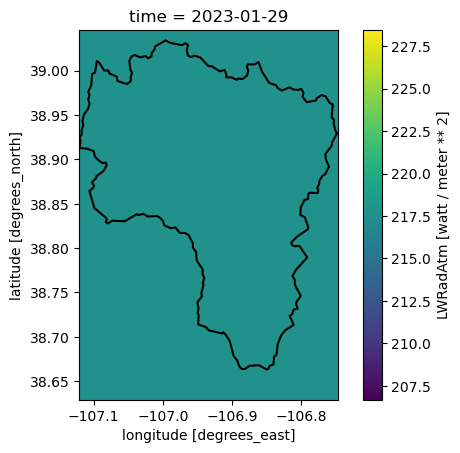

In [ ]:
fig, ax = plt.subplots()
forcing_ds['pptrate'].sel(time="2023-01-29").plot(ax=ax)
gdf.boundary.plot(ax=ax, color="black")
